# Imports das bibliotecas necessárias

In [1]:
!pip install LTNtorch

In [2]:
pip install --upgrade ltn


In [3]:
import numpy as np
import pandas as pd
import ltn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import ltn
import torch
import torch.nn as nn
import torch.optim as optim

# Processamento do dataset

In [4]:
trains_100 = '/content/trains-uptated.csv'
df100 = pd.read_csv(trains_100, delimiter=",")

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

def transform_dataframe(df):
    # Lista para conter as novas linhas
    transformed_rows = []

    for idx, row in df.iterrows():
        train_number = idx
        num_cars = row["Number_of_cars"]
        num_loads = row["Number_of_different_loads"]
        direction = row["Class_attribute"]
        # Itera em cada vagão do trem
        for i in range(1, num_cars):
            car_number = i
            num_wheels = row[f"num_wheels{i}"]
            length = row[f"length{i}"]
            shape = row[f"shape{i}"]
            num_loads_i = row[f"num_loads{i}"]
            load_shape = row[f"load_shape{i}"]

            # Determina os próximos valores de forma com base na forma atual
            match shape:
              case _ if "circle" in shape:
                  next_crc = row["Circle_next_to_circle"]
                  next_hex = 0
                  next_rec = 0
                  next_tri = 0
              case _ if "rect" in shape:
                  next_crc = row["Rectangle_next_to_circle"]
                  next_hex = row["Rectangle_next_to_hexagon"]
                  next_rec = row["Rectangle_next_to_rectangle"]
                  next_tri = row["Rectangle_next_to_triangle"]
              case _ if "tri" in shape:
                   next_crc = row["Triangle_next_to_circle"]
                   next_hex = row["Triangle_next_to_hexagon"]
                   next_rec = 0
                   next_tri = row["Triangle_next_to_triangle"]
              case _ if "hex" in shape:
                  next_crc = row["Hexagon_next_to_circle"]
                  next_hex = row["Hexagon_next_to_hexagon"]
                  next_rec = 0
                  next_tri = 0
              case _:
                  next_crc = 0
                  next_hex = 0
                  next_rec = 0
                  next_tri = 0

            # Insere a nova linha
            transformed_rows.append({
                "train_number": train_number,
                "num_cars": num_cars,
                "num_loads": num_loads,
                "num_wheels": num_wheels,
                "car_number": car_number,
                "length": length,
                "shape": shape,
                "num_cars_loads": num_loads_i,
                "load_shape": load_shape,
                "next_crc": next_crc,
                "next_hex": next_hex,
                "next_rec": next_rec,
                "next_tri": next_tri,
                "direction": direction
            })

    # Crie um novo DataFrame a partir das linhas transformadas
    transformed_df = pd.DataFrame(transformed_rows)
    return transformed_df


transformed_df = transform_dataframe(df100)

In [6]:
transformed_df

,train_number,num_cars,num_loads,num_wheels,car_number,length,shape,num_cars_loads,load_shape,next_crc,next_hex,next_rec,next_tri,direction
0,0,4,2.0,2,1,long,openrect,1.0,rectanglod,0,0,0,1,east
1,0,4,2.0,2,2,short,openrect,1.0,trianglod,0,0,0,1,east
2,0,4,2.0,2.0,3,long,closedrect,3.0,rectanglod,0,0,0,1,east
3,1,4,2.0,2,1,short,openrect,2.0,circlelod,1,0,0,0,east
4,1,4,2.0,2,2,short,closedtrap,1.0,rectanglod,0,0,0,0,east
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,98,3,1.0,2,1,short,slopetoprect,1.0,trianglod,0,0,0,0,west
308,98,3,1.0,2,2,short,openrect,1.0,trianglod,0,0,0,0,west
309,99,4,3.0,2,1,short,opentrap,1.0,rectanglod,0,0,0,0,west
310,99,4,3.0,2,2,short,opentrap,1.0,circlelod,0,0,0,0,west


In [7]:
str_att = {
     "length": ["short", "long"],
     "shape": [
          'closedblopnrect',
          'closedrect',
          'closedtrap',
          'closedushaped',
          'dblopnrect',
          'ellipse',
          'hexagon',
          'jaggedrect',
          'openrect',
          'opentrap',
          'slopetopdblopnrect',
          'slopetoprect',
          'slopetoptrap',
          'slopetopushaped',
          'ushaped',
      ],
     "load_shape": [
          'circlelod',
          'hexagonlod',
          'rectanglod',
          'trianglod',
     ],

     "Class_attribute": ["west", "east"],
 }

def read_data(path):
    # Lê o CSV apenas uma vez
    df = pd.read_csv(path, delimiter=",", keep_default_na=False)

    # Processa as colunas com base em str_att
    for k in df.columns:
        for att in str_att:
            if k.startswith(att):  # Verifica se o nome da coluna começa com uma chave de str_att
                for i, val in enumerate(df[k]):
                    if val in str_att[att]:
                        # Exceção para "west" e "east" (Class_attribute)
                        if att == "Class_attribute":
                            if val == "west":
                                df.at[i, k] = 0
                            elif val == "east":
                                df.at[i, k] = 1
                        else:
                            df.at[i, k] = str_att[att].index(val) + 1

    # Substituições globais no DataFrame
    df.replace("\0", 0, inplace=True)
    df.replace("None", -1, inplace=True)
    df.replace("none", -1, inplace=True)

    df.index = df.index + 1

    return df

data = read_data(trains_100)
data


<ipython-input-7-70c96bb6ae7d>:51: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("None", -1, inplace=True)


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
1,4,2,2,2,9,1,3,2,1,9,...,1,0,0,0,0,0,0,0,0,1
2,4,2,2,1,9,2,1,2,1,3,...,0,0,1,0,0,0,0,0,0,1
3,4,3,2,1,15,1,4,2,1,9,...,1,0,1,0,0,0,0,0,0,1
4,5,3,2,1,10,1,1,2,1,15,...,1,0,0,0,0,1,0,0,0,1
5,4,3,2,1,2,1,4,2,1,3,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,5,3,2,1,9,3,3,2,1,7,...,0,0,1,1,0,1,0,0,0,0
97,3,2,2,1,7,2,1,2,2,2,...,0,0,1,0,0,0,0,0,0,0
98,3,2,2,1,12,1,1,3,2,2,...,0,0,0,1,0,0,0,0,0,0
99,3,1,2,1,12,1,4,2,1,9,...,0,0,0,1,0,0,0,0,0,0


## Separa os Dados de Leste e Oeste

In [8]:
east_trains = data[data['Class_attribute'] == 0]  # Leste
west_trains = data[data['Class_attribute'] == 1]  # Oeste

## Divide os dados em 70% para treino e 30% para teste, garantindo o balanceamento entre leste e oeste.

In [9]:
# Separa 70% dos dados para treino e 30% para teste
train_east, test_east = train_test_split(east_trains, test_size=0.3, random_state=42)
train_west, test_west = train_test_split(west_trains, test_size=0.3, random_state=42)

# Combina os dados de treino e teste
train_data = pd.concat([train_east, train_west])
test_data = pd.concat([test_east, test_west])


In [10]:
X_train = train_data.drop(columns=['Class_attribute'])  # Colunas de características
Y_train = train_data['Class_attribute']  # Rótulos (0 ou 1)

X_test = test_data.drop(columns=['Class_attribute'])
Y_test = test_data['Class_attribute']


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Construção do modelo de rede neural - (previsão da classe binária: leste ou oeste)

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float32)  # Converte para PyTorch com float32
X_test = torch.tensor(X_test, dtype=torch.float32)

# Converte Y_train e Y_test para tensores PyTorch (rótulos inteiros)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32).view(-1, 1)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32).view(-1, 1)

# Variáveis LTN no formato PyTorch
x = ltn.Variable("x", X_train)
y = ltn.Variable("y", Y_train)

## Definindo modelo



In [13]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))

model = SimpleModel()

In [14]:
def fuzzy_binary_crossentropy(x, y):
    y_pred = model(x)  # Predição do modelo
    loss = nn.BCELoss()(y_pred, y)  # Calcula BCE
    return 1.0 - loss  # Inverte para lógica fuzzy

In [15]:
# Define o axioma com o quantificador universal
def loss_fn():
    fuzzy_values = [fuzzy_binary_crossentropy(X_train[i].view(1, -1), Y_train[i].view(1, -1))
                    for i in range(X_train.shape[0])]
    return torch.mean(torch.stack(fuzzy_values))  # Agrega os valores fuzzy

# Configuração do otimizador
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Treinamento

Epoch 1, Loss: 0.2935980558395386, Train Accuracy: 0.4143
Epoch 2, Loss: 0.277948260307312, Train Accuracy: 0.3857
Epoch 3, Loss: 0.26032230257987976, Train Accuracy: 0.3714
Epoch 4, Loss: 0.24133668839931488, Train Accuracy: 0.3429
Epoch 5, Loss: 0.21902251243591309, Train Accuracy: 0.3286
Epoch 6, Loss: 0.1931503862142563, Train Accuracy: 0.3429
Epoch 7, Loss: 0.16311049461364746, Train Accuracy: 0.3286
Epoch 8, Loss: 0.1275303214788437, Train Accuracy: 0.3286
Epoch 9, Loss: 0.08649300038814545, Train Accuracy: 0.3429
Epoch 10, Loss: 0.03892901912331581, Train Accuracy: 0.3429
Final Test Accuracy: 0.4667, Final Test Loss: 0.7077


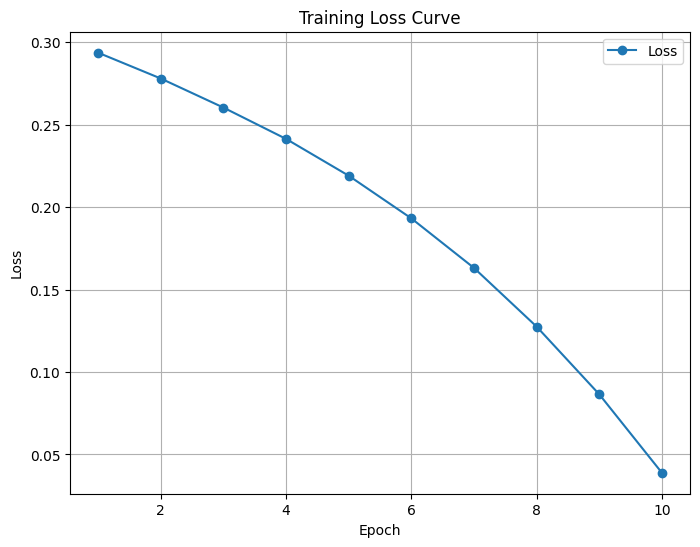

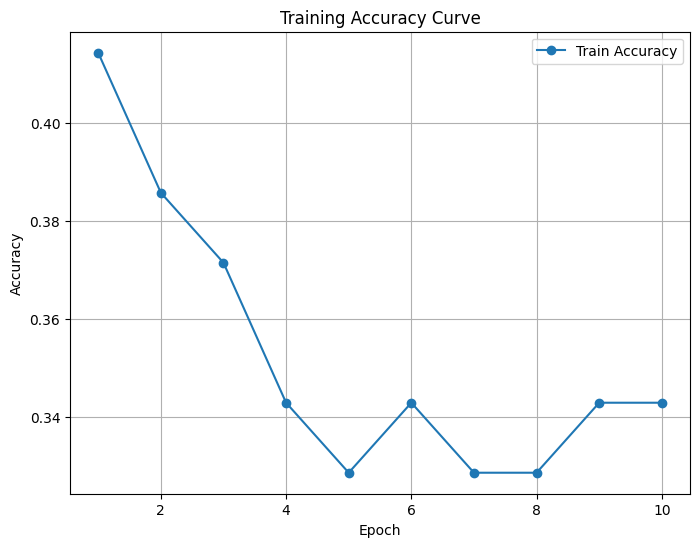

In [16]:
import matplotlib.pyplot as plt

# Listas para armazenar perdas e acurácias
loss_values = []
train_accuracies = []

# Função para calcular a acurácia
def calculate_accuracy(model, X, Y):
    with torch.no_grad():
        y_pred = model(X)
        y_pred_labels = (y_pred >= 0.5).float()  # Classes 0 ou 1
        correct = (y_pred_labels == Y).sum().item()
        total = Y.size(0)
        return correct / total

# Função para calcular a perda
def calculate_loss(model, X, Y):
    with torch.no_grad():
        y_pred = model(X)
        loss = nn.BCELoss()(y_pred, Y)
    return loss.item()

# Loop de treinamento
for epoch in range(10):
    optimizer.zero_grad()
    current_loss = loss_fn()  # Calcula a perda com lógica fuzzy
    current_loss.backward()
    optimizer.step()

    # Salva perda na lista
    loss_values.append(current_loss.item())

    # Calcula acurácia no treinamento
    train_acc = calculate_accuracy(model, X_train, Y_train)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}, Loss: {current_loss.item()}, Train Accuracy: {train_acc:.4f}")

# Calcula e mostra a perda e a acurácia no conjunto de teste após o treinamento
test_acc = calculate_accuracy(model, X_test, Y_test)
test_loss = calculate_loss(model, X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.4f}, Final Test Loss: {test_loss:.4f}")

# Curva de perda
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.legend()
plt.show()

# Curva de acurácia no treinamento
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.grid()
plt.legend()
plt.show()

# Saída da rede neural

In [17]:
import pandas as pd

def create_results_dataframe(model, X, Y, class_mapping={1: "east", 0: "west"}):
    results = []
    with torch.no_grad():
        y_pred = model(X)
        y_pred_values = y_pred.squeeze().numpy()  # Valores contínuos do modelo
        y_desired = Y.squeeze().numpy()          # Rótulos verdadeiros

        for i in range(len(y_pred_values)):
            predicted_class = class_mapping[int(y_desired[i])]
            results.append({
                "Train": i + 1,
                "Output of flat network": y_pred_values[i],
                "Desired output": y_desired[i],
                "Class": predicted_class
            })

    df = pd.DataFrame(results)
    return df

results_df = create_results_dataframe(model, X_test, Y_test)
results_df.to_csv("test_set_results.csv", index=False)
print("Results saved to 'test_set_results.csv'")

Results saved to 'test_set_results.csv'


In [18]:
results_df

,Train,Output of flat network,Desired output,Class
0,1,0.624739,0.0,west
1,2,0.587081,0.0,west
2,3,0.647352,0.0,west
3,4,0.740727,0.0,west
4,5,0.521295,0.0,west
5,6,0.466937,0.0,west
6,7,0.424476,0.0,west
7,8,0.601653,0.0,west
8,9,0.605743,0.0,west
9,10,0.561406,0.0,west


In [26]:
df100[(df100['length1']=='short') & (df100['Class_attribute']=='west')]

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
25,5,2.0,2,short,closedrect,1.0,trianglod,2,short,opentrap,...,0,0,0,0,0,1,0,0,0,west
26,4,3.0,2,short,openrect,1.0,circlelod,2,short,opentrap,...,1,0,0,0,0,1,0,0,0,west
27,4,2.0,2,short,dblopnrect,1.0,circlelod,3,long,closedrect,...,0,0,0,0,0,0,0,1,0,west
28,3,2.0,2,short,closedrect,1.0,rectanglod,2,short,openrect,...,0,0,1,0,0,0,0,0,0,west
29,5,4.0,2,short,openrect,1.0,rectanglod,3,long,jaggedrect,...,1,0,0,0,0,1,0,0,0,west
30,5,3.0,2,short,closedrect,1.0,rectanglod,2,short,openrect,...,1,1,0,0,0,0,0,0,0,west
31,4,2.0,2,short,ellipse,1.0,trianglod,3,long,openrect,...,0,0,0,0,0,1,0,0,1,west
32,5,2.0,2,short,slopetoptrap,1.0,circlelod,2,short,opentrap,...,0,0,0,0,0,1,0,0,1,west
33,5,4.0,3,short,openrect,1.0,circlelod,2,short,slopetoprect,...,1,0,0,0,0,1,0,0,0,west
34,3,1.0,2,short,closedushaped,1.0,trianglod,2,short,openrect,...,0,0,0,1,0,0,0,0,0,west
